In [21]:
using PyPlot
using PyCall
using Printf
@pyimport matplotlib.animation as anim
@pyimport matplotlib.patches as patches

In [22]:
using Base64
function showanim(filename)
    base64_video = base64encode(open(filename))
    display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
end

showanim (generic function with 1 method)

In [23]:
mutable struct World
    objects
    debug
    time_span
    time_interval
    ani
end

World() = World([], false, 10, 1, nothing)
World(debug) = World([], debug, 10, 1, nothing)
World(time_span, time_interval) = World([], false, time_span, time_interval, nothing)

function append(self::World, obj)
    push!(self.objects, obj)
end

function init_draw(self::World, ax)
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
end

function draw(self::World)
    fig, ax = subplots()
    init_draw(self, ax)    
    elems = []

    if self.debug
        for i = 1:1000
            one_step(self, i, elems, ax)
        end
    else
        self.ani = anim.FuncAnimation(fig, one_step, fargs=(self, elems, ax), 
            frames = Int(self.time_span/self.time_interval)+1, interval = Int(self.time_interval*1000))
        self.ani[:save]("test.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    end 
    
end

function one_step(i,self::World,elems, ax)
    plt.cla()
    init_draw(self, ax)
    while length(elems) > 0
        pop!(elems)
    end
    vcat(elems, ax.text(-4.4, 4.5, string("t = ", @sprintf("%.2f[s]", self.time_interval * i) ), fontsize=10))
    for obj in self.objects
        draw(obj, ax, elems)
        if applicable(one_step, obj, 1.0)
            one_step(obj, 1.0)
        end
    end
end

one_step (generic function with 1 method)

In [24]:
mutable struct Landmark
    pos
    id
end

Landmark(pos) = Landmark(pos, nothing)

function draw(self::Landmark, ax, elems)
    c = ax.scatter(self.pos[1], self.pos[2], s=100, marker="*", label="landmarks", color="orange")
    elems = vcat(elems, c)
    elems = vcat(elems, ax.text( self.pos[1], self.pos[2] , string("id:", string(self.id)), fontsize=10))
end

draw (generic function with 3 methods)

In [25]:
mutable struct Map
    landmarks
end

Map() = Map([])

function append_landmark(self::Map, landmark)
    landmark.id = length(self.landmarks)
    push!(self.landmarks, landmark)
end

function draw(self::Map, ax, elems)
    for lm in self.landmarks
        draw(lm, ax, elems)
    end
end

draw (generic function with 3 methods)

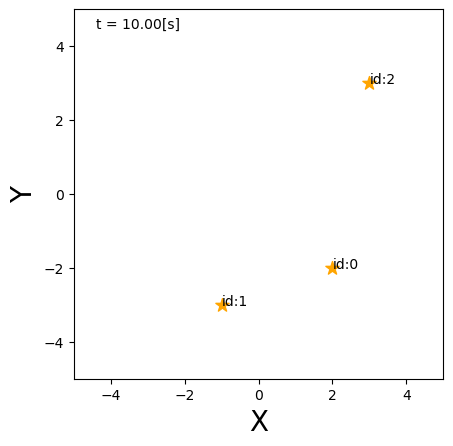

In [26]:
world = World(10, 0.5)

m = Map()
append_landmark(m, Landmark([2,-2]))
append_landmark(m, Landmark([-1,-3]))
append_landmark(m, Landmark([3,3]))
append(world, m)

draw(world)

In [27]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAHDptZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MiBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEDNliIQAFv/+99M/zLLr9zm146j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FghEPzIoq68AAAMAyoAXqEf/CmOPgAS+o/4U+3GcjnaQCVQrSiMBHWa7/x8xHwnGftHIjEI+CaLXGu4OdilRzg+3WJ5/X/yOnu2raA1CBBfiYP2q5fTTcV7SODiWT5HWS5Z0XWgXo/gnB9zXNGz7seKd3jgxv/UU3zoLNdeyNEdF7fO8D3HC0qRelCNjddX/7zbzjotT0pu7SF7YLubnfMtdpE3zEyZVWX4TX/vFThjIHL/MAHy0PuHUT2rXL0tW32lOdUmoKI1/EDolGXqaFTgZIO6rTgsJfN616ER2UOZQHdsZDFSuSkX29e97p9tmOu78RFZzy4Jgs3WC/ehqe3WVa2Gb1rp2BDfJc0dKcj3+waBX6pAVk+B+T3kuymbuIQtJbi7EvRjLUAdRRgPP5sUgNaxqArqfFtw0IESd+YMkMdRWQDHsMzoE+c8bWHKsc6xl06Hc2AvhcxP8c7yFrtpSq3tT94DZy05Qw44EObF66ae8erB/e9Lvrgl94MgdlWWRxGZUkHahqTAwnaZQxp4LUTEe1D61y5MA5kr5wdzlUGmnjcVGTJHgryzDt0AahS50CYTGjT2izE3ZXFR4DCECoZld4BWVtclWSemXDDooxFoxCBljzoZI3j4QQmYAHosicxUbN8xvypT4U/GGe2it5JDoMGVHrvyL1/8NEeaTKIPisjKBg8ft5SzMDRb3Wj6g73NG+6YenSIkXzPgDIG6mbZTvILZKkuXJqsCv5NS4KJzBVz1JyK4PGU7uP9lYS8zThQiz03QeGsMr0b2YQIWlIEcKs/VVqcPeG4WQRTl8Qh4XmWEWSBF93ymY86JPJVSozAADt+KSDAnVKWBgpwC+q0ylvhFqMDDctfgSyGNpspeDfbiGbTG4/hSg751clnNRKRruZ1ClFxLDs7XEmN6pFrsn8uII+mu5IVykBPnkc78ln+PYoQvgaPLJ3sri1HIW7OdveaRLiHTng9V5q7gqirJa9L8rp5eKi/zWKX/OQnnvoSAnBjtRrkJ/SsPTvkEcVwN/AIqPnWDaonHdUpWyZqadRUDhCpvnU55RwUMufbUHRBWaKLA79W7Pab0bYjQT8N2uo6+9JvMud8vAxlq0zjeVzZCY4ao4JQCzXKRFRHmt0HWRRFTY8hdUP7t2XIcsc8iQ8kr7FrkKOJ5zpfzlyLvBaRz82bBBolYeKTYfaUdrjlg2xBg/EcRIps7WVp99xGWcJL0ie3zhlVTHzj0PiocWDIZqg8LWkTw6w4xZAK7M6BFRjVQRbSpTkece49cURXLdutHJmH3CsUwYAg4THe3sKrcf3sUmOleRZxa1uBMRpwoJrOVnRuvuZ9gypQ+6L3anXHWhXN++spM/ja6Tv/cKMT2zEkt/64D5jn0JfWu72LIFWY7WSmFyRgfjLpwom20luyMaKe2Ewf69YHc0OBoesEzTj/d5ddU3/ceLayWTVubTbEQNpibl9522c1MtYfh8CxlxK1kUpJaihkppoaGkxwumI7+qglQGCd490Ci0n2CB+8TuwZj35GzVuVBToCRuFm9Va7yCgDxcdD/+N8lgLQe/ozZc0VO6//j2Yw2HT96Mk3eRCP8YkKP4V/dngxTzuK57O25BilGKHIhRqEWbbdG4HZMyiFjdhJ2pJj/0sjgSTxW970mfqmwq42jRKUXVazfKRozmnF12I6PoR+L1ETbyfvQmEmLCMdYrUvO6rsz22TJs8/R7r8h3PR5eNi99dCHSdIWezX4lr4r1VZtCxGrFWX+WmlW5aT12TDi8HnmSoip3MIZucwhD0shZy4SQX02kxgfvfwZ5EPsIsn4xOXNfqAfYAS4dpAwFLok0qDUH2ihOayMzVC+1mhTpNty3e+sZbXnRw6l8+nAbjVIIX8GMZ8WNyBwzlQjvfMmhOR65QFSbomgLeKS/9a9Ows9q7k84N0XhDtdRCWfQtHG9FaBHUZXYw1qgOUQZNY8INdt6PPVsfMs2vQAZGLGpGhzkGn7iF4eZbQtCMsmL2d2J+YF8QFe1/c8DZXmMYBT8AKBRxdUhGzAO6NP71nJS1yWkfDqG6oGgpz5fLtsirMRK5fVlLJRP4Meyws4nBC0F7ErWOTugsk2JKpfXvHsYrzDBzBuWhF3iCD9R9TBqwfYaFuVK9wKVVSlbiTwpIyWlILlbRu8JHiuEhXF5eHQeLC6rIbK1bFNPNsCWeq9Ez5CXto9LZGpmeNGF3gz31XlxctMyZ5Xv5WO2VTUzfbUSnQ8s4ikm0oOYhCINMxeO9yxDm2M6YXpKgzHVEUv2c+vFQYlD4X/q45TrlXWAAADAAADAjR8bD8QSXldfpoCrGS6dYur+GbaoomH6b8H9igP8TzxuSF+Uxzp5GopGTIGRcejBWxwkplVyJqMaA3pDocfwhfNFjWDzMWzc5HIVIctrm7gUyRdgNeQmQ6VoodOy1I2PICAV+cqQtQUKVCGyvKYlPyAHGVj1tq3HiaspgT0HpTtNDEApxVGL5J1wIXKKHAweEO3TCejKeb0su0vrWzxoz6l2ToCnS9K0ue7HTuyLVlVkbVxc/VtXCTsAtz8FRfQdmTc/1rLzHXGP9gUnkaerhfmVjKHXRMmVuXvDRZAHKetVaFLjyBQroctHfEeQ4Y7vSSiUqLD4S+tnfCg8AjLCz+sRhjKdEVtPw/IAGVIxvrqptzcMLnf4y0uRT1J6rDQMTMF/GtYDaR047++NqrDhezvvBXDbE9oIKakTpkPaK536pxt6xwXQyd+qfKcqZD6QJWZpabdSbrb4ELZQmk4g8GnZvqRRqX0n4tLR8Kbi/PcADiO9dPIiEyw4EcZ3ha9DcZArv9NgkoQfTCrxPRxd69JWvcqNz4Df9+/tiZnUj6vgUaTc4Tja6NhMqFKEn8Bj3A1/mMlQIW0rl6+QC6Rt2VDNY4e/THLpA9TDuO